# OpenCV 얼굴 검출 종합 노트북

**Google Colab** 환경에서 실행 가능한 **Haar, LBP 기반 **얼굴 검출** 예시를 모두 담고 있습니다.

## 목차
1. **이론**: 얼굴 검출 기법(Haar, LBP, DNN) 개요
2. **필수 라이브러리 설치**
3. **모델 파일 다운로드 및 체크** (LBP xml, TF .pb/.pbtxt)
4. **이미지 업로드** & Haar 검출, LBP 검출, TF DNN 검출
5. **추가 예제**: 동영상 처리 + NMS
6. **오류 해결 가이드**
7. **Q&A 및 과제**


# 1. 얼굴 검출 이론 보강

## 1.1 Haar Cascade
- **Viola-Jones**(2001) 방식.
- Harr-like feature와 **Adaboost**를 활용.
- 정면 얼굴 검출에 널리 쓰였고, 매우 빠르며 CPU로도 실시간 가능.
- 조명 변화나 각도(측면)에 약할 수 있음.

## 1.2 LBP(Local Binary Pattern) Cascade
- Haar와 유사한 캐스케이드 구조이나, feature가 LBP를 기반.
- 특정 상황(조명 등)에서 Haar보다 나을 수도 있지만, 큰 차이는 아님.


# 2. 필수 라이브러리 설치

In [1]:
!pip install opencv-python opencv-python-headless matplotlib dlib --quiet
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib
import os
print("OpenCV version:", cv2.__version__)

OpenCV version: 4.10.0


# 3. 모델 파일 다운로드 및 체크
### 3.1 LBP Cascade 파일
OpenCV에 내장된 `lbpcascade_frontalface.xml`이 없는 경우, GitHub에서 **lbpcascade_frontalface_improved.xml**를 다운로드합니다.

In [2]:
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/data/lbpcascades/lbpcascade_frontalface_improved.xml

if not os.path.exists('lbpcascade_frontalface_improved.xml'):
    print("LBP cascade XML download failed!")
else:
    print("LBP cascade XML ready.")

LBP cascade XML ready.


# 4. 이미지 업로드 & Haar, LBP, DNN 검출 실습
## 4.1 이미지 업로드
Colab에서 이미지를 업로드해서 사용합니다.
```python
from google.colab import files
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
```


In [3]:
from google.colab import files
print("얼굴 이미지 파일을 업로드하세요.")
uploaded = files.upload()

image_path = list(uploaded.keys())[0]
print(f"Uploaded: {image_path}")

얼굴 이미지 파일을 업로드하세요.


Saving iu3.png to iu3.png
Uploaded: iu3.png


## 4.2 Haar Cascade 검출
```python
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
)
faces = face_cascade.detectMultiScale(gray, 1.1, 5)
```

Detected 2 faces (Haar)


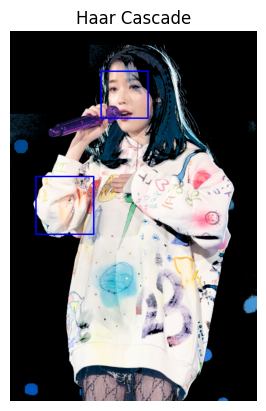

In [4]:
def detect_faces_haar(image_path, scaleFactor=1.1, minNeighbors=5):
    img = cv2.imread(image_path)
    if img is None:
        print("Failed to load image:", image_path)
        return
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Haar Cascade
    haar_xml = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
    face_cascade = cv2.CascadeClassifier(haar_xml)
    if face_cascade.empty():
        print("Haar cascade not found.")
        return

    faces = face_cascade.detectMultiScale(
        gray, scaleFactor=scaleFactor, minNeighbors=minNeighbors, minSize=(30,30)
    )
    print(f"Detected {len(faces)} faces (Haar)")
    for (x,y,w,h) in faces:
        cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Haar Cascade')
    plt.axis('off')
    plt.show()

# Test
detect_faces_haar(image_path, 1.1, 5)

## 4.3 LBP Cascade 검출
```python
lbp_cascade = cv2.CascadeClassifier('lbpcascade_frontalface_improved.xml')
faces = lbp_cascade.detectMultiScale(gray, 1.1, 5)
```

Detected 1 faces (LBP)


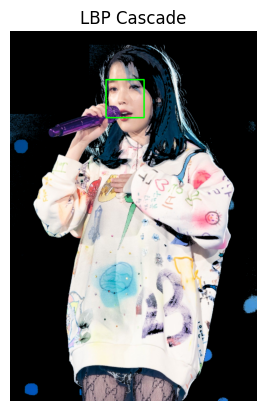

In [5]:
def detect_faces_lbp(image_path, scaleFactor=1.1, minNeighbors=5):
    img = cv2.imread(image_path)
    if img is None:
        print("Failed to load image:", image_path)
        return
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    lbp_xml = 'lbpcascade_frontalface_improved.xml'
    if not os.path.exists(lbp_xml):
        print("LBP XML not found. Download or check path.")
        return

    lbp_cascade = cv2.CascadeClassifier(lbp_xml)
    if lbp_cascade.empty():
        print("LBP cascade is empty.")
        return

    faces = lbp_cascade.detectMultiScale(
        gray, scaleFactor=scaleFactor, minNeighbors=minNeighbors
    )
    print(f"Detected {len(faces)} faces (LBP)")
    for (x,y,w,h) in faces:
        cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('LBP Cascade')
    plt.axis('off')
    plt.show()

# Test
detect_faces_lbp(image_path, 1.1, 5)

# 과제

0.6569529085872576


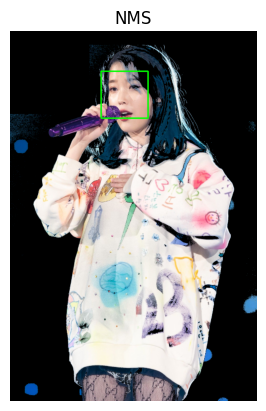

In [6]:
# nms 함수
# 파라미터로 iou의 임계값을 입력해준다.
def nms(iou_threshold):
  img = cv2.imread(image_path)
  if img is None:
      print("Failed to load image:", image_path)
      return
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Haar Cascade
  haar_xml = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
  face_cascade = cv2.CascadeClassifier(haar_xml)
  if face_cascade.empty():
      print("Haar cascade not found.")
      return

  # haar cascade의 결과로 나온 좌표값을 faces_haar에 저장
  faces_haar = face_cascade.detectMultiScale(
      gray, scaleFactor=1.1, minNeighbors=5, minSize=(30,30)
    )

  # lbp cascade
  lbp_xml = 'lbpcascade_frontalface_improved.xml'
  if not os.path.exists(lbp_xml):
      print("LBP XML not found. Download or check path.")
      return

  lbp_cascade = cv2.CascadeClassifier(lbp_xml)
  if lbp_cascade.empty():
      print("LBP cascade is empty.")
      return
  # lbp_cascade의 결과로 나온 좌표값을 lbp_cascade에 저장
  faces_lbp = lbp_cascade.detectMultiScale(
      gray, scaleFactor=1.1, minNeighbors=5
    )

  # 루프를 돌면서 모든 bounding box에 대해 검사한다.
  for face in faces_haar:
    x_h, y_h, w_h, h_h = face
    for lbp in faces_lbp:
      x_l, y_l, w_l, h_l = lbp

      # haar와 lbp의 좌표값을 이용해서 두 개의 bounding box가 겹치는 공간의 좌표를 찾는다.
      # x,y가 좌측 상단에서 시작하기 때문에 좌측 상단의 좌표는 max
      x1_i = max(x_h, x_l)
      y1_i = max(y_h, y_l)
      # 우측 하단의 좌표는 min
      x2_i = min(x_h+w_h, x_l+w_l)
      y2_i = min(y_h+h_h, y_l+h_l)

      # 겹치는 공간의 width와 height를 계산
      # 겹치지 않는다면 음수가 나와서 0이 된다.
      i_width = max(0, x2_i-x1_i)
      i_height = max(0, y2_i-y1_i)

      # 겹치는 공간의 면적
      i_area = i_width * i_height

      # 각 bounding box의 면적
      # haar
      area1 = w_h * h_h
      # lbp
      area2 = w_l * h_l

      # iou 계산을 위해 합집합을 구한다.
      u_area = area1+area2-i_area

      iou = i_area / u_area

      # 계산된 iou가 입력된 임계값을 넘는다면 실행
      if iou > iou_threshold:
        # iou 값을 출력한다.
        print(iou)
        # haar의 bounding box가 더 크다면 haar를 사용
        if area1 >= area2:
          cv2.rectangle(img, (x_h,y_h), (x_h+w_h,y_h+h_h), (0,255,0), 2)
        else:
          cv2.rectangle(img, (x_l,y_l), (x_l+w_l,y_l+h_l), (0,255,0), 2)

  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title('NMS')
  plt.axis('off')
  plt.show()

nms(0.4)